<div class="alert alert-block alert-success">
<h3><center style="line-height: 1">MSDS-422: Practical Machine Learning</center></h3>
<h1><center style="line-height: 1">Final Project: Group 5</center></h1>
<h2><center style="line-height: 1">Identifying Malware in Network Traffic with Supervised Learning</center></h2>

<b>Group 5</b>:
<ul>
    <li>Aishwarya Mathuria</li>
    <li>Akshaya Venkat Raman</li>
    <li>Tanmay Swami</li>
    <li>Yatika Taneja</li>
</ul>
</div>

In [29]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import glob
from datetime import datetime
import ipaddress
from collections import Counter
from scipy import stats
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Load Dataset</h1>
</div>

In [31]:
# Load all CSV files without any cleaning
print("Loading raw data")
csv_files = glob.glob('data/*.csv')
print(f"Found {len(csv_files)} CSV files:")
for file in sorted(csv_files):
    size_mb = Path(file).stat().st_size / (1024 * 1024)
    print(f"  - {file}: {size_mb:.2f} MB")

all_dataframes = []

for file in csv_files:
    try:
        print(f"Loading {file}...")
        df = pd.read_csv(file, sep='|')
        all_dataframes.append(df)
        print(f"  - Loaded {len(df)} records")
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not all_dataframes:
    raise ValueError("No data files could be loaded")

df = pd.concat(all_dataframes, ignore_index=True)
print(f"\nCombined raw dataset shape: {df.shape}")

# Combine label and detailed-label
df['label'] = df['label'].astype(str)
df['detailed-label'] = df['detailed-label'].astype(str)
df['detailed-label'].replace('nan', pd.NA, inplace=True)
combined = df['label'] + ' ' + df['detailed-label']
df['label'] = combined.where(
    (df['label'] != 'Benign') & df['detailed-label'].notna(),
    df['label'])
df['label'] = df['label'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Drop detailed-label column
if 'detailed-label' in df.columns:
    df.drop(columns=['detailed-label'], inplace=True)
df.replace('-', pd.NA, inplace=True)

Loading raw data
Found 1 CSV files:
  - data/CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv: 442.23 MB
Loading data/CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv...
  - Loaded 3581028 records

Combined raw dataset shape: (3581028, 23)


In [32]:
print("\nUpdated label distribution:")
print(df['label'].value_counts())


Updated label distribution:
label
Malicious DDoS             3578457
Benign                        2476
Malicious C&C HeartBeat         95
Name: count, dtype: int64


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Exploratory Data Analysis</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Basic dataset Information</h3>
</div>

In [35]:
print("\n")
print(f"Total records: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"Shape: {df.shape}")
df.info(memory_usage='deep')
print("\n")



Total records: 3581028
Total columns: 22
Shape: (3581028, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3581028 entries, 0 to 3581027
Data columns (total 22 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ts              float64
 1   uid             object 
 2   id.orig_h       object 
 3   id.orig_p       float64
 4   id.resp_h       object 
 5   id.resp_p       float64
 6   proto           object 
 7   service         object 
 8   duration        object 
 9   orig_bytes      object 
 10  resp_bytes      object 
 11  conn_state      object 
 12  local_orig      object 
 13  local_resp      object 
 14  missed_bytes    float64
 15  history         object 
 16  orig_pkts       float64
 17  orig_ip_bytes   float64
 18  resp_pkts       float64
 19  resp_ip_bytes   float64
 20  tunnel_parents  object 
 21  label           object 
dtypes: float64(8), object(14)
memory usage: 2.9 GB




In [36]:
numeric_cols = ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [37]:
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label
0,1.568940e+09,CEjjLs1iwWYrt8C4O6,192.168.1.195,123.0,212.111.30.190,123.0,udp,<NA>,0.008239,96.0,...,<NA>,<NA>,0.0,Dd,2.0,152.0,2.0,152.0,<NA>,Benign
1,1.568940e+09,CHNzmm3tMu5Gse9Zvg,192.168.1.195,123.0,89.221.218.101,123.0,udp,<NA>,0.007496,96.0,...,<NA>,<NA>,0.0,Dd,2.0,152.0,2.0,152.0,<NA>,Benign
2,1.568940e+09,CDlbowGNUwsHckADd,192.168.1.195,37120.0,102.165.48.81,17769.0,tcp,<NA>,1.848549,518.0,...,<NA>,<NA>,0.0,ShAdfDr,10.0,1572.0,8.0,540.0,<NA>,Malicious C&C HeartBeat
3,1.568940e+09,CxKxhj4MGsf5GcqoX6,192.168.1.1,47805.0,192.168.1.195,22.0,tcp,<NA>,206.663644,2768.0,...,<NA>,<NA>,0.0,DdAaFf,400.0,26336.0,268.0,36368.0,<NA>,Benign
4,1.568940e+09,C2n3PK3bA92hAgTHda,192.168.1.195,37122.0,102.165.48.81,17769.0,tcp,<NA>,1.902519,518.0,...,<NA>,<NA>,0.0,ShAdfDr,10.0,1572.0,8.0,540.0,<NA>,Malicious C&C HeartBeat


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Columns</h3>
</div>

In [39]:
print("Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

Columns:
    1. ts
    2. uid
    3. id.orig_h
    4. id.orig_p
    5. id.resp_h
    6. id.resp_p
    7. proto
    8. service
    9. duration
   10. orig_bytes
   11. resp_bytes
   12. conn_state
   13. local_orig
   14. local_resp
   15. missed_bytes
   16. history
   17. orig_pkts
   18. orig_ip_bytes
   19. resp_pkts
   20. resp_ip_bytes
   21. tunnel_parents
   22. label


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Data types</h3>
</div>

In [41]:
print(df.dtypes.value_counts())

float64    11
object     11
Name: count, dtype: int64


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing values</h3>
</div>

,MissingValues,Percent
tunnel_parents,3581028,100.00
local_orig,3581028,100.00
local_resp,3581028,100.00
service,3581026,100.00
duration,3580404,99.98
orig_bytes,3580404,99.98
resp_bytes,3580404,99.98
history,1,0.00


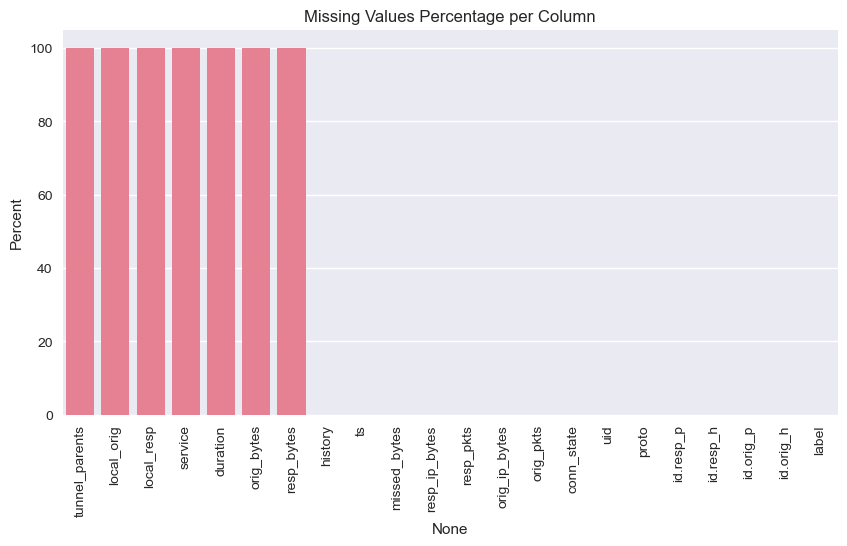

In [43]:
# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'MissingValues': missing, 'Percent': missing_percent})
display(missing_df[missing_df.MissingValues > 0])

# Visualize missing values
plt.figure(figsize=(10,5))
sns.barplot(x=missing_df.index, y=missing_df['Percent'])
plt.xticks(rotation=90)
plt.title("Missing Values Percentage per Column")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value Distribution</h3>
</div>

label
Malicious DDoS             3578457
Benign                        2476
Malicious C&C HeartBeat         95
Name: count, dtype: int64


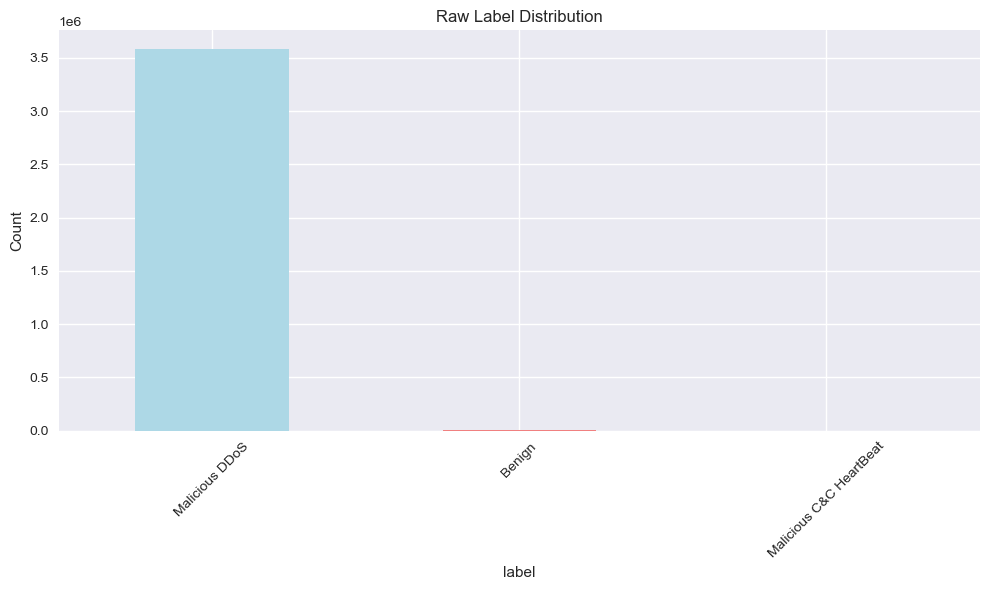

In [45]:
label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Raw Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Histograms for numerical features</h3>
</div>

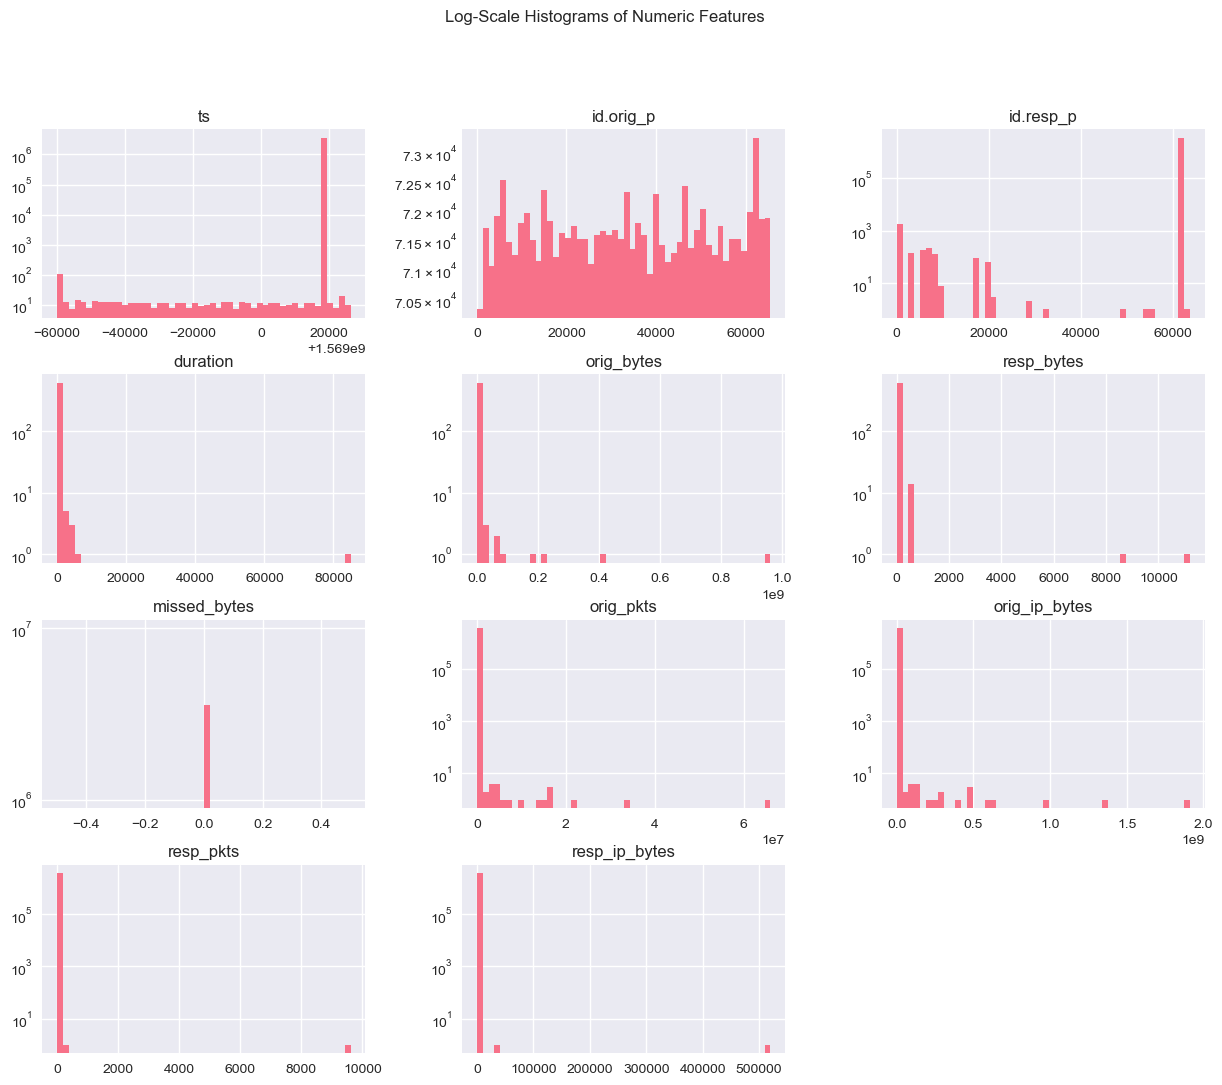

In [47]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(figsize=(15, 12), bins=50, log=True)
plt.suptitle("Log-Scale Histograms of Numeric Features")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation Heatmap</h3>
</div>

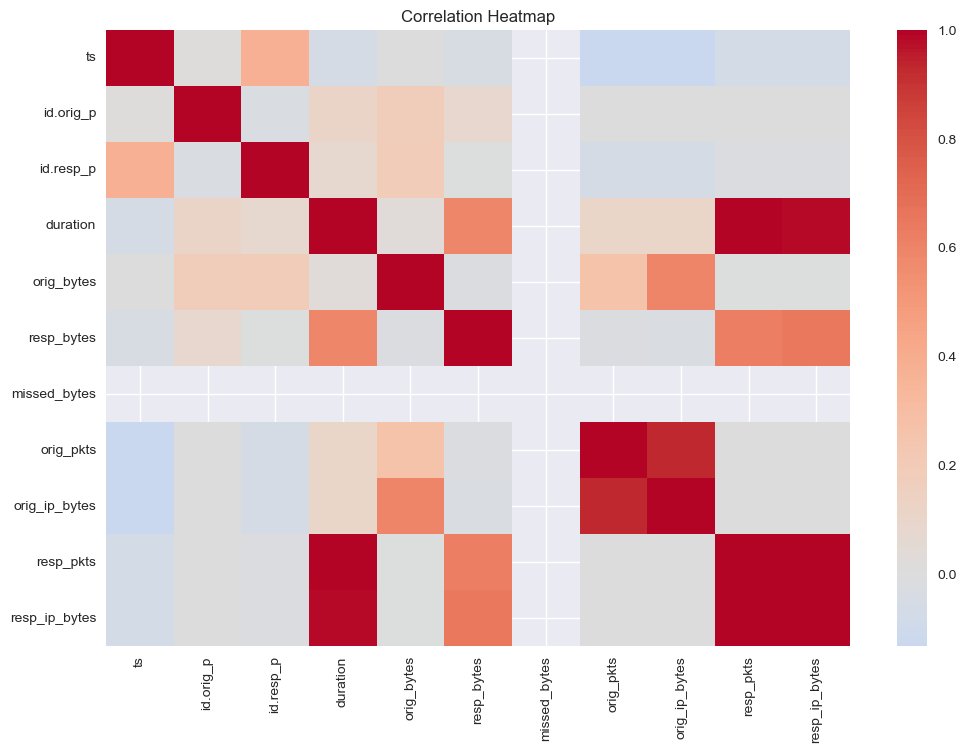

In [49]:
plt.figure(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Boxplots by Label</h3>
</div>

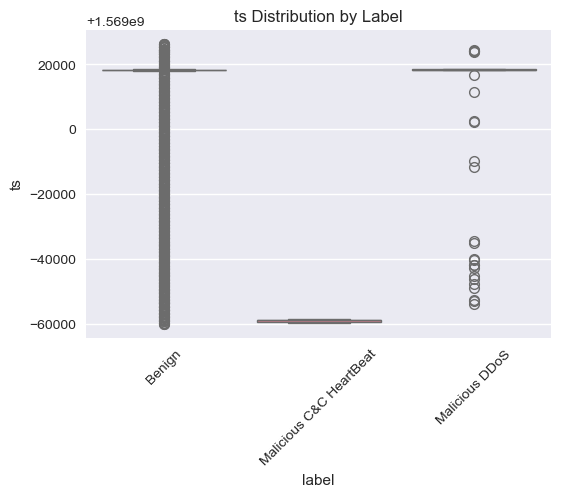

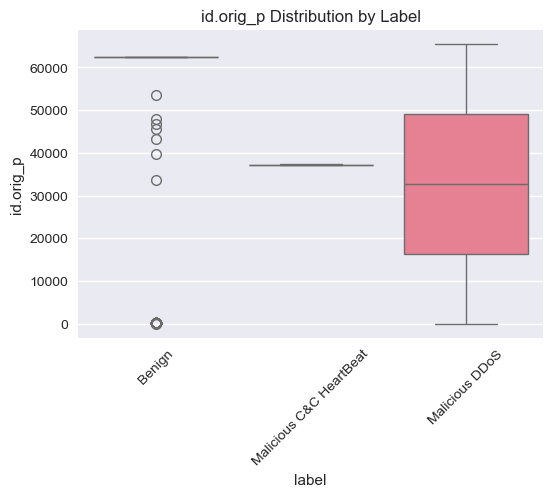

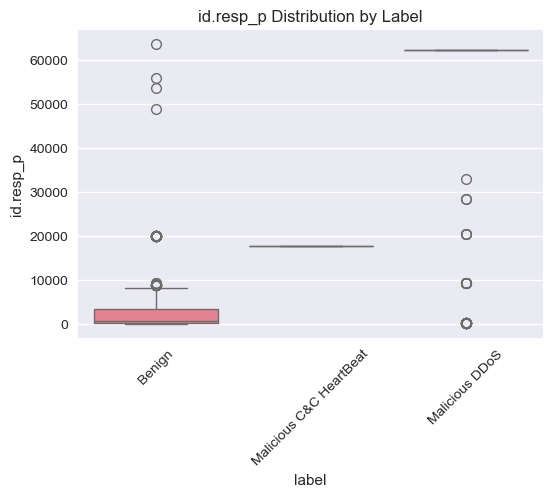

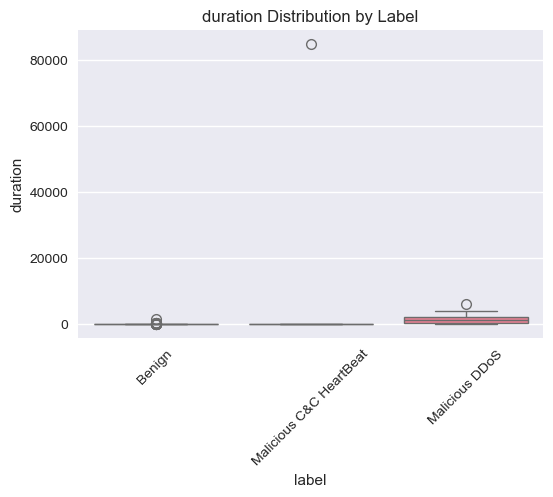

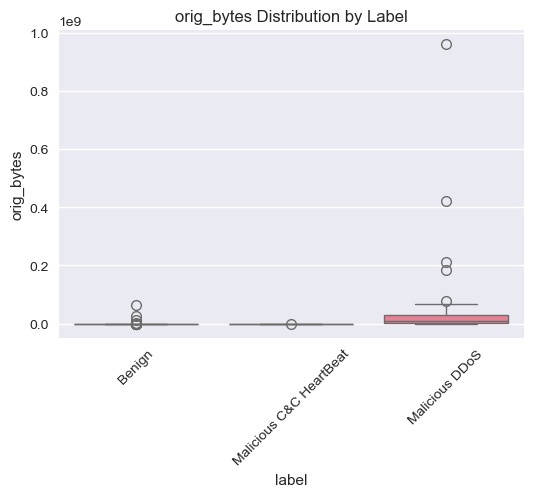

In [51]:
for col in numeric_cols[:5]:  # first 5 numeric features
    plt.figure(figsize=(6,4))
    sns.boxplot(x='label', y=col, data=df)
    plt.title(f"{col} Distribution by Label")
    plt.xticks(rotation=45)
    plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Outlier detection</h3>
</div>

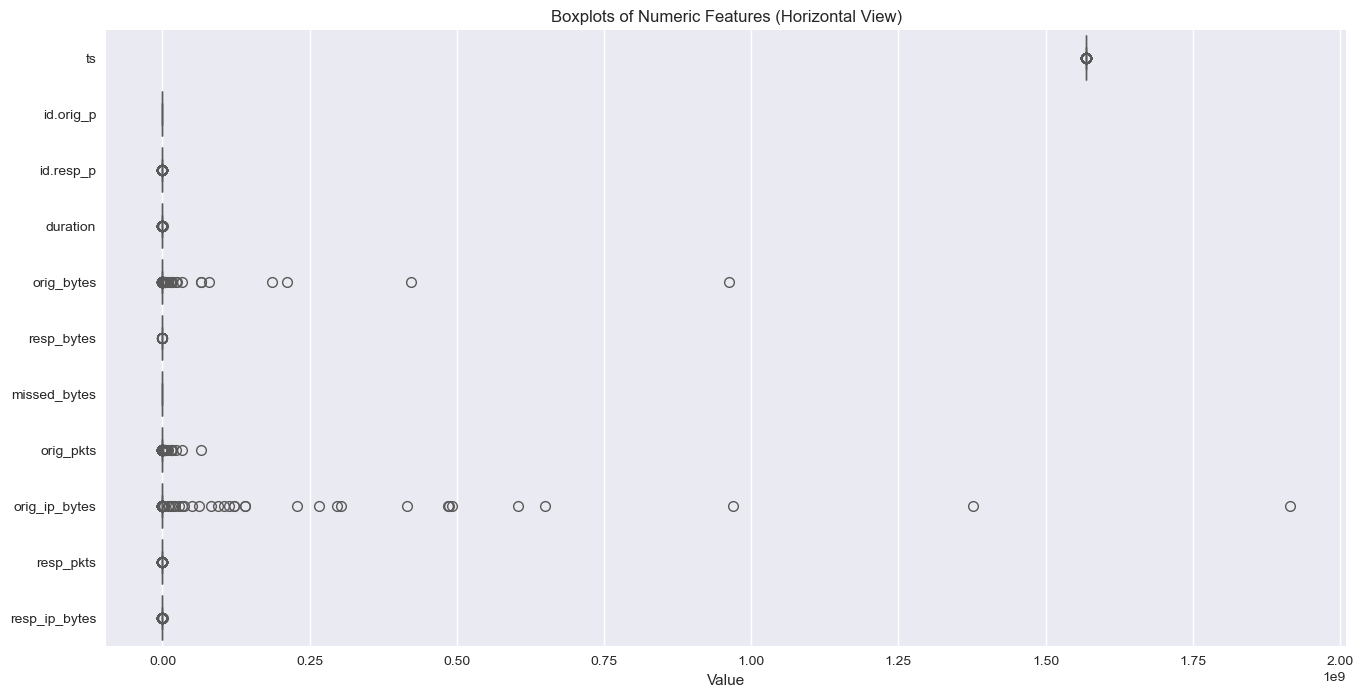

ts: 621 outliers
id.orig_p: 0 outliers
id.resp_p: 2637 outliers
duration: 139 outliers
orig_bytes: 138 outliers
resp_bytes: 16 outliers
missed_bytes: 0 outliers
orig_pkts: 624 outliers
orig_ip_bytes: 624 outliers
resp_pkts: 445 outliers
resp_ip_bytes: 445 outliers


In [53]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[numeric_cols], orient='h', palette='Set2')
plt.title("Boxplots of Numeric Features (Horizontal View)")
plt.xlabel("Value")
plt.show()

for col in numeric_cols:
    q1, q3 = np.percentile(df[col].dropna(), [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outlier_count} outliers")

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Data Cleaning and Preparation</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling missing values</h3>
</div>

In [56]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [57]:
for col in numeric_cols:
    if col in df.columns:
        print(f"Converting {col} to numeric...")
        df[col] = pd.to_numeric(df[col], errors='coerce')
        missing_before = df[col].isnull().sum()
        df[col] = df[col].fillna(0)
        missing_after = df[col].isnull().sum()
        print(f"    Missing values: {missing_before} -> {missing_after}")

Converting ts to numeric...
    Missing values: 0 -> 0
Converting id.orig_p to numeric...
    Missing values: 0 -> 0
Converting id.resp_p to numeric...
    Missing values: 0 -> 0
Converting duration to numeric...
    Missing values: 3580404 -> 0
Converting orig_bytes to numeric...
    Missing values: 3580404 -> 0
Converting resp_bytes to numeric...
    Missing values: 3580404 -> 0
Converting missed_bytes to numeric...
    Missing values: 0 -> 0
Converting orig_pkts to numeric...
    Missing values: 0 -> 0
Converting orig_ip_bytes to numeric...
    Missing values: 0 -> 0
Converting resp_pkts to numeric...
    Missing values: 0 -> 0
Converting resp_ip_bytes to numeric...
    Missing values: 0 -> 0


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Feature Engineering</h3>
</div>

In [59]:
if {'TotalBytes', 'TotalPackets', 'Duration'}.issubset(df.columns):
    df['BytesPerPacket'] = df['TotalBytes'] / (df['TotalPackets'] + 1)
    df['PacketsPerSecond'] = df['TotalPackets'] / (df['Duration'] + 1e-6)

# Encode Protocols
if 'Protocol' in df.columns:
    df = pd.get_dummies(df, columns=['Protocol'], drop_first=True)

# Convert IP addresses to numeric
import ipaddress
def ip_to_int(ip):
    try:
        return int(ipaddress.IPv4Address(ip))
    except:
        return None

for col in ['SourceIP','DestinationIP']:
    if col in df.columns:
        df[col+'_int'] = df[col].apply(ip_to_int)

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Convert timestamp to datetime</h3>
</div>

In [61]:
print("Converting timestamps")
df['timestamp'] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
invalid_timestamps = df['timestamp'].isnull().sum()
print(f"    Invalid timestamps: {invalid_timestamps}")

# Adding temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
print("Added hour and day_of_week features")

Converting timestamps
    Invalid timestamps: 0
Added hour and day_of_week features


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling IP addresses and ports</h3>
</div>

In [63]:
print("Processing origin IP addresses...")
df['is_private_orig'] = df['id.orig_h'].apply(lambda x: 
    ipaddress.ip_address(x).is_private if pd.notna(x) else False)

print("Processing response IP addresses...")
df['is_private_resp'] = df['id.resp_h'].apply(lambda x: 
    ipaddress.ip_address(x).is_private if pd.notna(x) else False)

Processing origin IP addresses...
Processing response IP addresses...


In [64]:
# Categorize ports into common service types
def categorize_port(port):
    try:
        port = int(port)
        if port <= 1024:
            return 'well_known'
        elif port <= 49151:
            return 'registered'
        else:
            return 'dynamic'
    except:
        return 'unknown'

print("Categorizing origin ports...")
df['orig_port_category'] = df['id.orig_p'].apply(categorize_port)
    
print("Categorizing response ports...")
df['resp_port_category'] = df['id.resp_p'].apply(categorize_port)

Categorizing origin ports...
Categorizing response ports...


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling duplicates</h3>
</div>

In [66]:
duplicates_before = df.duplicated().sum()
df = df.drop_duplicates()
duplicates_after = df.duplicated().sum()
print(f"Removed {duplicates_before - duplicates_after} duplicate rows")

Removed 0 duplicate rows


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Class Imbalance Handling</h3>
</div>

In [68]:
nan_summary = df.isna().sum()
print(nan_summary[nan_summary > 0])
X = df[numeric_cols]
y = df['label']

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("\n\nShape before SMOTE:", df.shape)
print("\nClass distribution before SMOTE:", y.value_counts())
print("\n\nShape after SMOTE:", df.shape)
print("\nClass distribution after SMOTE:", y_res.value_counts())

df = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name='label')], axis=1)

service           3581026
local_orig        3581028
local_resp        3581028
history                 1
tunnel_parents    3581028
dtype: int64


Shape before SMOTE: (3581028, 29)

Class distribution before SMOTE: label
Malicious DDoS             3578457
Benign                        2476
Malicious C&C HeartBeat         95
Name: count, dtype: int64


Shape after SMOTE: (3581028, 29)

Class distribution after SMOTE: label
Benign                     3578457
Malicious C&C HeartBeat    3578457
Malicious DDoS             3578457
Name: count, dtype: int64


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Label encoding categorical values</h3>
</div>

In [70]:
# Identify columns with only 1 unique value
single_value_cols = [col for col in df.columns if df[col].nunique() <= 1]

print("Dropping columns with a single unique value:", single_value_cols)

# Drop these columns
df = df.drop(columns=single_value_cols)

Dropping columns with a single unique value: ['missed_bytes']


In [71]:
encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
    print(f"Encoded column '{col}' with {len(le.classes_)} classes")

Encoded column 'label' with 3 classes


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Post Cleanup Analysis and Processing</h1>
</div>

In [73]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing Values</h3>
</div>

In [75]:
missing_after = df.isnull().sum()
print("Missing values after cleanup:")
print(missing_after[missing_after > 0])

Missing values after cleanup:
Series([], dtype: int64)


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Negative values check</h3>
</div>

In [77]:
for col in numeric_cols:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"{col}: {negative_count} negative values")
        else:
            print(f"{col}: No negative values")

ts: No negative values
id.orig_p: No negative values
id.resp_p: No negative values
duration: No negative values
orig_bytes: No negative values
resp_bytes: No negative values
orig_pkts: No negative values
orig_ip_bytes: No negative values
resp_pkts: No negative values
resp_ip_bytes: No negative values
label: No negative values


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value distribution</h3>
</div>

label
0    3578457
1    3578457
2    3578457
Name: count, dtype: int64


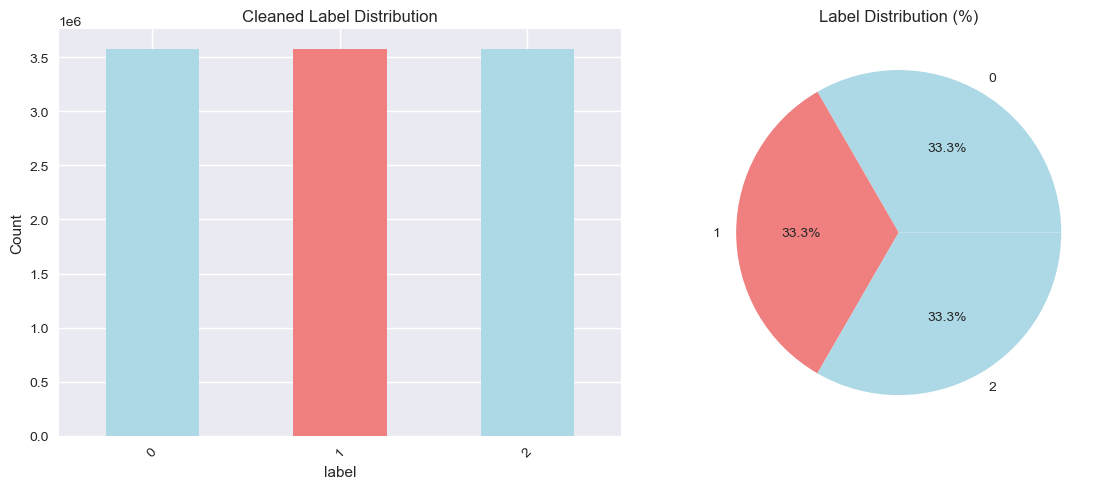

Class imbalance ratio: 1.00


In [79]:
label_counts = df['label'].value_counts()
print(label_counts)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Cleaned Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'])
plt.title('Label Distribution (%)')
plt.tight_layout()
plt.savefig('cleaned_label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Class imbalance ratio: {label_counts[1] / label_counts[0]:.2f}")

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Traffic statistics</h3>
</div>

Traffic Statistics Summary:
           duration    orig_bytes    resp_bytes     orig_pkts     resp_pkts
count  1.073537e+07  1.073537e+07  1.073537e+07  1.073537e+07  1.073537e+07
mean   1.476143e+02  9.279731e+03  3.346363e+01  1.289350e+03  1.852109e+01
std    2.875018e+03  6.445561e+05  3.108154e+02  1.025829e+05  3.253215e+02
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
75%    9.333699e-02  0.000000e+00  0.000000e+00  2.000000e+00  2.000000e+00
max    8.497074e+04  9.623472e+08  1.121600e+04  6.602735e+07  9.613000e+03


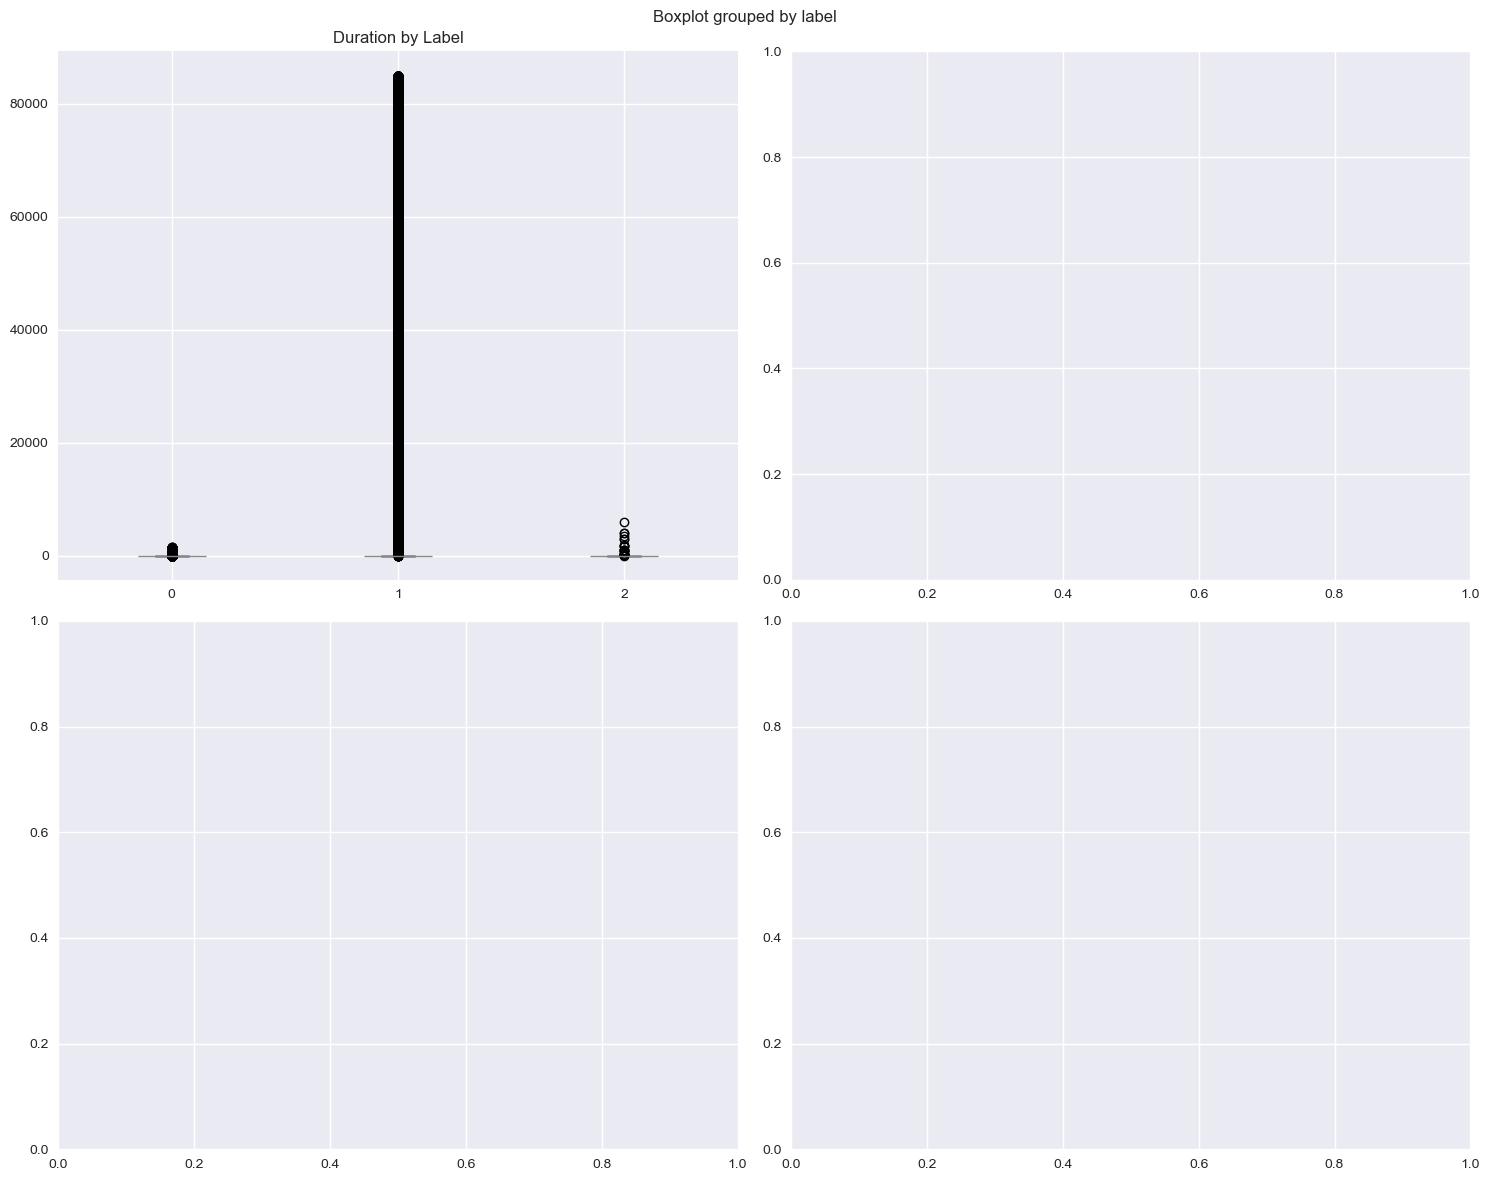

In [81]:
traffic_cols = ['duration', 'orig_bytes', 'resp_bytes', 'total_bytes', 'orig_pkts', 'resp_pkts', 'total_packets', 'bytes_per_packet']

available_traffic_cols = [col for col in traffic_cols if col in df.columns]
if available_traffic_cols:
    print("Traffic Statistics Summary:")
    print(df[available_traffic_cols].describe())
    
    # Plot traffic statistics by label
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Traffic Statistics by Label (Cleaned)', fontsize=16)
    
    for i, col in enumerate(['duration', 'total_bytes', 'total_packets', 'bytes_per_packet']):
        if col in df.columns:
            row, col_idx = i // 2, i % 2
            df.boxplot(column=col, by='label', ax=axes[row, col_idx])
            axes[row, col_idx].set_title(f'{col.title()} by Label')
            axes[row, col_idx].set_xlabel('')
    plt.tight_layout()
    plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation analysis</h3>
</div>

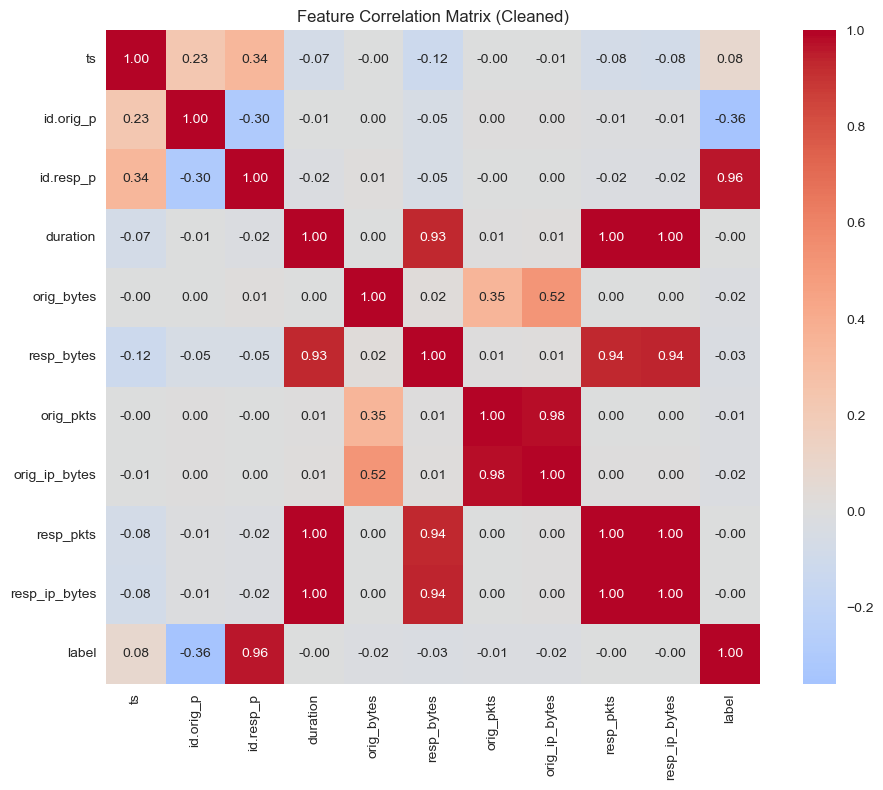

In [83]:
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Feature Correlation Matrix (Cleaned)')
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Scaling and Train-Test Split</h3>
</div>

In [ ]:
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_res)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Cross Validation</h1>
    <ul>
        <li>XGBoost</li>
        <li>Random Forest</li>
        <li>LiteGBM</li>
        <li>Extra Trees</li>
        <li>Gradient Boost Trees</li>
    </ul>
</div>

In [ ]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=100, force_col_wise=True, random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    print(f"\nTraining {name} with PCA features...")
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    results.append({
        'Model': name,
        'Mean F1-Score': np.mean(scores),
        'Std Dev': np.std(scores)
    })

results_df = pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)
results_df